In [3]:
import numpy as np
import pandas as pd 
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
import datetime  

In [4]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021,4,30)

data = web.DataReader("AAPL", 'yahoo', start, end)


In [5]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.553024
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.564355
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.459940
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.447999
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.490866


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2851 entries, 2010-01-04 to 2021-04-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2851 non-null   float64
 1   Low        2851 non-null   float64
 2   Open       2851 non-null   float64
 3   Close      2851 non-null   float64
 4   Volume     2851 non-null   float64
 5   Adj Close  2851 non-null   float64
dtypes: float64(6)
memory usage: 155.9 KB


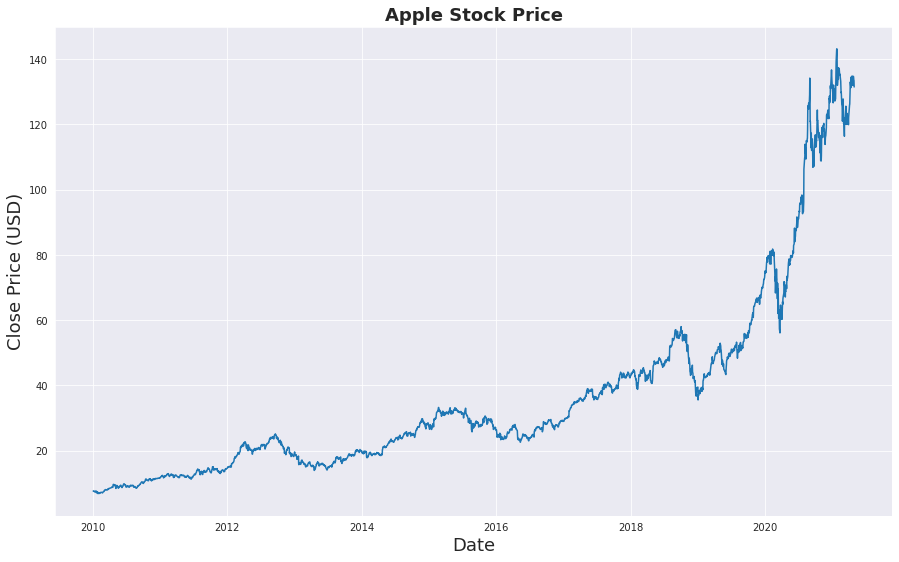

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.title("Apple Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [8]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2851 entries, 2010-01-04 to 2021-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2851 non-null   float64
dtypes: float64(1)
memory usage: 44.5 KB


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [11]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2265, 19, 1)
y_train.shape =  (2265, 1)
x_test.shape =  (566, 19, 1)
y_test.shape =  (566, 1)


In [12]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.45152801275253296
Epoch  1 MSE:  0.29242321848869324
Epoch  2 MSE:  0.13900135457515717
Epoch  3 MSE:  0.01951714977622032
Epoch  4 MSE:  0.26278209686279297
Epoch  5 MSE:  0.07122405618429184
Epoch  6 MSE:  0.02118789032101631
Epoch  7 MSE:  0.04270360991358757
Epoch  8 MSE:  0.0660371482372284
Epoch  9 MSE:  0.07780985534191132
Epoch  10 MSE:  0.07894280552864075
Epoch  11 MSE:  0.0725284069776535
Epoch  12 MSE:  0.061649832874536514
Epoch  13 MSE:  0.049155719578266144
Epoch  14 MSE:  0.03765755146741867
Epoch  15 MSE:  0.029369978234171867
Epoch  16 MSE:  0.025728663429617882
Epoch  17 MSE:  0.02687373384833336
Epoch  18 MSE:  0.03121933713555336
Epoch  19 MSE:  0.03586103767156601
Epoch  20 MSE:  0.0383589044213295
Epoch  21 MSE:  0.03793392330408096
Epoch  22 MSE:  0.03530241176486015
Epoch  23 MSE:  0.031824301928281784
Epoch  24 MSE:  0.02871311642229557
Epoch  25 MSE:  0.02665615826845169
Epoch  26 MSE:  0.025802694261074066
Epoch  27 MSE:  0.02593307942152023

In [17]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

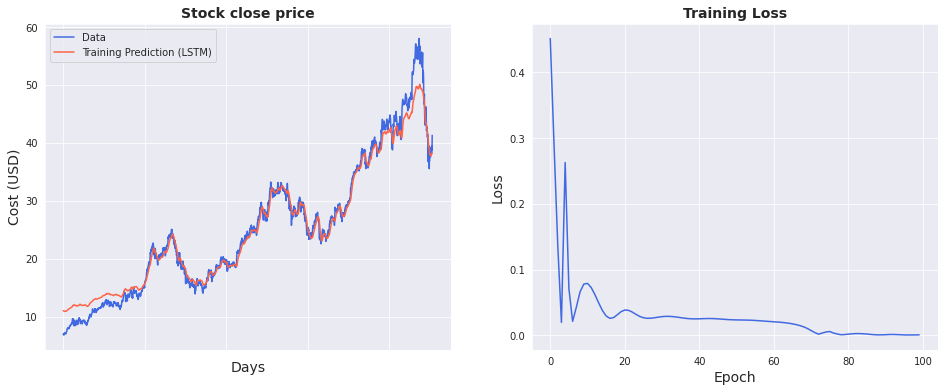

In [19]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock close price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [20]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1.72 RMSE
Test Score: 34.40 RMSE
